In [69]:
from sklearn.model_selection import KFold
import polars as pl

TARGET = 'diagnosis'

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    return df_train, df_test

def get_x_y(df):
    X, y = df.drop(['id', TARGET]), df.get_column(TARGET) # we don't care about the ID column either
    return X.to_numpy(), y.to_numpy()

df = pl.read_csv('data.csv', has_header=True)
df_train, df_test = fetch_data(df, 0)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
926424,"""M""",21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,0.1726,0.05623,1.176,1.256,7.673,158.7,0.0103,0.02891,0.05198,0.02454,0.01114,0.004239,25.45,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115
926682,"""M""",20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.0395,0.01678,0.01898,0.002498,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
926954,"""M""",16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,0.159,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.0473,0.01557,0.01318,0.003892,18.98,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782
927241,"""M""",20.6,29.33,140.1,1265.0,0.1178,0.277,0.3514,0.152,0.2397,0.07016,0.726,1.595,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.74,39.42,184.6,1821.0,0.165,0.8681,0.9387,0.265,0.4087,0.124
92751,"""B""",7.76,24.54,47.92,181.0,0.05263,0.04362,0.0,0.0,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.0,0.0,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0,0.0,0.2871,0.07039


In [70]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.9736842105263158

In [71]:
def svm(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, y_train = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, y_train)
    return model.score(X_test, y_test)

scores = [svm(df, x) for x in range(5)]
scores

[0.9736842105263158,
 0.9824561403508771,
 0.9736842105263158,
 0.956140350877193,
 0.9734513274336283]

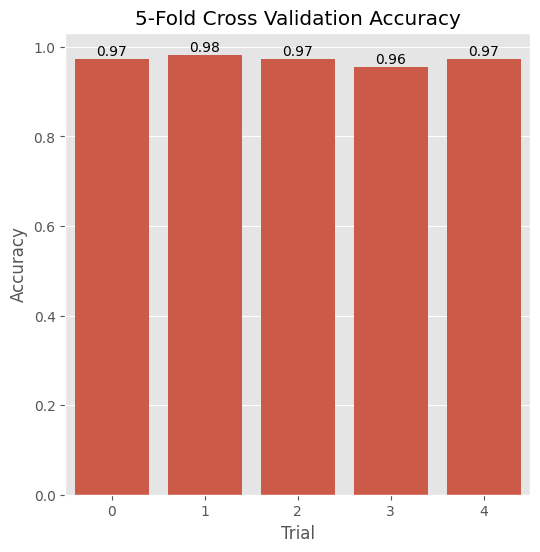

In [72]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

f, ax = plt.subplots(1, figsize=(6, 6))
COLORS = seaborn.color_palette()

plot_df = pd.DataFrame.from_dict({'Accuracy': scores, 'Trial': list(range(5))})
ax.set_title('5-Fold Cross Validation Accuracy')
seaborn.barplot(data=plot_df, x='Trial', y='Accuracy', ax=ax, color=COLORS[0])
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")